In [ ]:
!pip install qualtran --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 909.4/909.4 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.3/535.3 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.0/168.0 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.8/249.8 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.8/177.8 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 55.7 MB/s eta

## QAOA
Given a classical cost function $C(z)$ defined on n-bit strings $z = (z_1, z_2, . . . , z_n) \in \{+1, −1\}^{n}$, the QAOA is a quantum algorithm that aims to find a string $z$ such that $C(z)$ is close to its absolute minimum. The cost function $C$ can be written as an operator that is diagonal in the computational basis, defined as

$$
C|z\rangle = C(z)|z\rangle
$$

The QAOA consists of two components that are repeatedly applied. The first component is parameterized evolution under the diagonal problem
Hamiltonian C,
$$
U_{C}(\gamma) = e^{-i\gamma C}
$$

The second component is parameterized evolution under a local transverse field driver Hamiltonian B,

$$
U_{B}(\beta) = e^{−i\beta B} = \prod_{j=1}^{n}e^{-i\beta X_{j}} \;;\;   B = \sum_{j=1}^{n}X_{j}
$$

The QAOA is a variational algorithm that uses repeated application of these unitaries to prepare a parameterized
state that is then optimized. The depth of the variational algorithm is usually denoted as “p” in the QAOA literature.
Specifically, for depth p we prepare a state parameterized by $\gamma = (\gamma_1, . . . , \gamma_p)$ and $\beta = (\beta_1, . . . , \beta_p)$

$$
|\gamma, \beta\rangle = U_{B}(\beta_p) U_{C}(\gamma_p) ... U_{B}(\beta_1) U_{C}(\gamma_1) |+\rangle^{\otimes n}
$$

For a given p, we attempt to find parameters that minimize the expectation value of the cost
$$
\langle C \rangle = \langle \gamma, \beta | C | \gamma, \beta \rangle
$$

## SK Model

The Sherrington-Kirkpatrick (SK) model describes a classical spin system with all-to-all couplings between the $n$ spins. The classical cost function $C$ is defined as:
$$
C(z) = \sum_{j < k}^{n} w_{j, k} z_{j} z_{k} \; \text{where}\;  w_{j, k} \in \{+1, -1\}
$$

By adding a global phase factor, we can shift the values of the weights s.t. $w_{j, k} \in \{0, 1\}$
## Analyzing costs of Phase Oracles $U_{C}(\gamma)$ for FT Resource Estimation
The phase oracle $O^{\text{phase}}(\gamma)$ is defined as
$$
    O^{\text{phase}}(\gamma) |z\rangle = e^{-i \gamma C(z)} |z\rangle
$$

In the notebook below, we will see different ways to implement the unitary $U_{C}(\gamma)$ that synthesizes the phase oracle and analyze fault tolerant costs for each of these.

## SKPhaseOracleNaiveRZZ

Since the $Z_{j}Z_{k}$ operators all commute with each other, a straightforward implementation of the phase oracle would be to write $U_{C}(\gamma)$ as follows:

$$
U_{C}(\gamma) = e^{-i\gamma C} = \prod_{j < k}^{n}e^{-i \gamma w_{j, k} Z_{j} Z_{k}}
$$

Thus, we can decompose $U_{C}(\gamma)$ into $\frac{n(n-1)}{2}$ 2-qubit operations. Each of the 2-qubit unitaries can be implemented in `Qualtran` as an `Rzz(theta)` gate.


The goal of this exercise is to implement a bloq called `SKPhaseOracleNaiveRZZ` for the naive phase oracle for the SK model

### Step-1: Implement a bloq for Rzz

The `Rzz(t)` gate implements the following unitary:

$$
  e^{-i Z⊗Z t/2} = \begin{bmatrix}
                    e^{-it/2} & & & \\
                    & e^{it/2} & & \\
                    & & e^{it/2} & \\
                    & & & e^{-it/2}
                    \end{bmatrix}
$$

We can decompose `Rzz(t)` gate into two `CNOTs` and 1 single qubit `Rz(t)` rotation. Goal of this exercise is to implement a new bloq for `Rzz` which decomposes into `CNOT` and `Rz` bloqs from `qualtran.basic_gates`

In [ ]:
import attrs
import sympy
import IPython
import numpy as np
from typing import Tuple, Dict, Set, Union
from numpy.typing import NDArray
from functools import cache, cached_property
from qualtran import Bloq, Signature, Register, QBit, QFxp, Side, QUInt
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma, show_bloqs
from qualtran.symbolics import SymbolicInt, SymbolicFloat, ceil, log2, HasLength, pi
from qualtran.bloqs.basic_gates import Rz, CZPowGate, Toffoli, CNOT
from qualtran.cirq_interop.t_complexity_protocol import TComplexity

@attrs.frozen
class Rzz(Bloq):
    r"""The two-qubit Rzz gate implements the unitary exp(-i Z⊗Z t/2)

    The Rzz(theta) gate implements the following unitary:

    $$
    e^{-i Z⊗Z t/2} = \begin{bmatrix}
                      e^{-it/2} & & & \\
                      & e^{it/2} & & \\
                      & & e^{it/2} & \\
                      & & & e^{-it/2}
                      \end{bmatrix}
    $$

    The gate can be decomposed into two CNOTs and a single Rz rotation
    as follows

    ```
                q[0]: ───@───────────@───
    Rzz(t) :=            │           │
                q[1]: ───X───Rz(t)───X───
    ```

    Args:
      theta: Angle of rotation
      eps: The accuracy with which we want to synthesize the rotation

    Registers:
      q: A 2-qubit register with dtype `QBit()` and shape `(2,)`
    """
    theta: SymbolicFloat
    eps: SymbolicFloat = 1e-11

    @cached_property
    def signature(self) -> Signature:
      # Exercise: Implement the signature of the bloq in terms of a single
      # register named "q" of dtype "QBit" and shape `(2,)` representing
      # two input wires for the Bloq.
      return Signature([Register('q', QBit(), shape=(2,))])

    def build_composite_bloq(
        self, bb: 'BloqBuilder', q: 'SoquetT'
    ) -> Dict[str, 'SoquetT']:
        # Exercise: Implement the decomposition of RZZ in terms of 2 CNOTs and 1 Rz gate.
        ...
        q[0], q[1] = bb.add(CNOT(), ctrl=q[0], target=q[1])
        q[1] = bb.add(Rz(angle=self.theta, eps=self.eps), q=q[1])
        q[0], q[1] = bb.add(CNOT(), ctrl=q[0], target=q[1])
        return {'q' : q}

t = sympy.Symbol('t')
show_bloqs([Rzz(t), Rzz(t).decompose_bloq()])

### Step-2: Implement a bloq for `SKPhaseOracleNaiveRZZ`

The bloq would simply decompose into $\frac{n(n - 1)}{2}$ `Rzz` rotations between each unique pair of qubits as described above to implement the following unitary

$$
U_{C}(\gamma) = e^{-i\gamma C} = \prod_{j < k}^{n}e^{-i \gamma w_{j, k} Z_{j} Z_{k}}
$$


We will implement the `Bloq.decompose_bloq()` method to implement the actual circuit and implement `Bloq.build_call_graph` to support symbolic cost analysis.

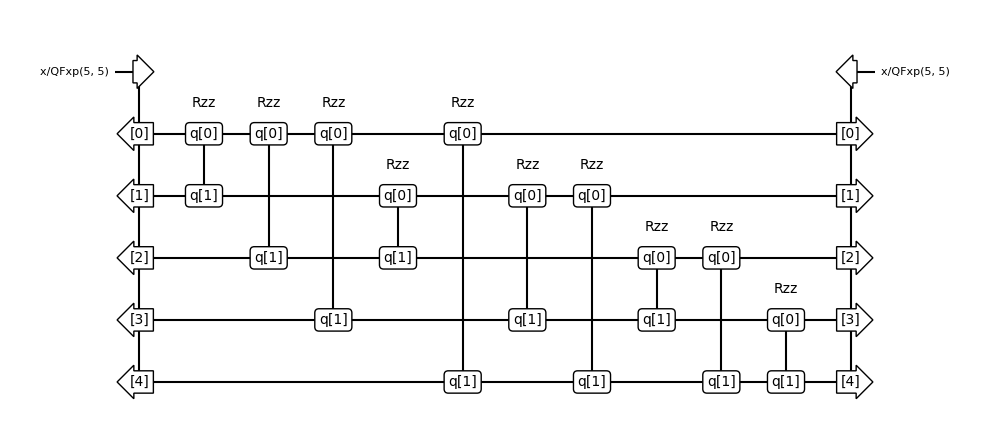

In [ ]:
from sympy.functions.combinatorial.factorials import binomial

def get_weights(n: SymbolicInt) -> Union[HasLength, Tuple[int, ...]]:
    if isinstance(n, sympy.Expr):
      return HasLength(binomial(n, 2))
    rng = np.random.default_rng(12345)
    return tuple((-1) ** rng.integers(low=0, high=1, size=(n * (n - 1)) // 2, endpoint=True)) # nC2 weights for the cost function.


@attrs.frozen
class SKPhaseOracleNaiveRZZ(Bloq):
    r"""Implements the problem-dependent unitary $U_{C}(γ)=\exp(-i γ C)$

    For the SK-model, the phase oracle $U_{C}(γ)$ can be expressed as
    $$
       U_{C}(γ) =\prod_{j<k}\exp(-i γ w_{j,k}Z_jZ_k)$
    $$

    Args:
      bitsize: Number of spins `n` in the SK model, which determine the size
        of the input register `x`.
      gamma: The classical constant s.t. each computational basis state is phased
        proportional to this constant. The γ in $U_{C}(γ)=\exp(-i γ C)$
      weights: A Tuple of length `nC2` specifying the weights of couplings between
        each pair of spins (represented as qubits). Can also be a symbolic
        object of type `HasLength`.
      eps: The accuracy which which we should synthesize the phase rotations.

    Registers:
      x: A `self.bitsize`-bit fixed-point register of type QFxp(self.bitsize, self.bitsize)
    """

    bitsize: SymbolicInt
    gamma: SymbolicFloat
    weights: Tuple[int, ...]
    eps: SymbolicFloat

    @cached_property
    def signature(self) -> Signature:
        # Exercise: Implement the Signature of the bloq using `Signature.build_from_dtypes`
        # helper method. The signature should have a single register called `x` of type
        # QFxp of size `self.bitsize` and all bits used for the fractional part.
        return Signature.build_from_dtypes(x=QFxp(self.bitsize, self.bitsize))

    def build_composite_bloq(
        self, bb: 'BloqBuilder', x: 'SoquetT'
    ) -> Dict[str, 'SoquetT']:
        # Split the soquet for register `x` so you get access to individual bits.
        # After the split, `x` is an array of length `self.bitsize` corresponding
        # to the individual bits.
        x = bb.split(x)
        w_idx = 0
        n = self.bitsize
        # We need to propagate the error correctly when synthesizing individual
        # rotations.
        eps_per_rotation = self.eps / int(binomial(n, 2))
        for i in range(n):
            for j in range(i + 1, n):
                # Exercise: Perform an Rzz rotation by angle self.weights[w_idx] * gamma.
                zzpow = Rzz(self.weights[w_idx] * self.gamma, eps_per_rotation)
                x[i], x[j] = bb.add(zzpow, q=[x[i], x[j]])
                w_idx = w_idx + 1
        # Join the n individual wires into a single wire before returning the soquet.
        # This is to make sure the returned wire matches the signature of the output
        # wire of this Bloq.
        x = bb.join(x)
        return {'x' : x}

    def build_call_graph(self, ssa: 'SympySymbolAllocator') -> Set['BloqCountT']:
        n = self.bitsize
        num_rotations = binomial(n, 2)
        return {(Rzz(self.gamma, eps=self.eps / num_rotations), num_rotations)}

    def __str__(self):
        return f'{self.__class__.__name__}[{self.gamma}, {self.eps}]'


phase_oracle = SKPhaseOracleNaiveRZZ(5, 0.1, get_weights(5), 0.1)
show_bloq(phase_oracle.decompose_bloq(), 'musical_score')
show_bloqs([phase_oracle, phase_oracle.decompose_bloq()])

### Step-3: Perform symbolic cost analysis for `SKPhaseOracleNaiveRZZ`

We can use the bloq implemented above to derive a symbolic expression for T gate costs and see that the cost scales as
$$
O(n \log{\frac{1}{\epsilon}})
$$

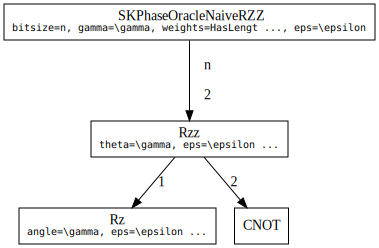

### TCounts for SKPhaseOracleNaiveRZZ(n, eps)

<IPython.core.display.Math object>

In [ ]:
from qualtran.drawing import show_call_graph, show_counts_sigma
from qualtran.resource_counting.t_counts_from_sigma import t_counts_from_sigma

@cache
def get_t_counts_for_bloq(bloq: 'Bloq'):
  _, sigma = bloq.call_graph()
  return t_counts_from_sigma(sigma)

def show_t_counts(bloq: 'Bloq', title: str):
  # Helper method to display total T gate counts of bloq
  IPython.display.display(IPython.display.Markdown(title))
  IPython.display.display(IPython.display.Math(sympy.latex(get_t_counts_for_bloq(bloq))))



n, gamma, eps = sympy.symbols('n, \gamma, \epsilon')

sk_phase_oracle_naive_rzz = SKPhaseOracleNaiveRZZ(n, gamma, get_weights(n), eps)
sk_phase_oracle_naive_rzz_g, sk_phase_oracle_naive_rzz_sigma = sk_phase_oracle_naive_rzz.call_graph()
show_call_graph(sk_phase_oracle_naive_rzz_g)

def get_sk_phase_oracle_naive_rzz_bloq(n, gamma, eps):
    return SKPhaseOracleNaiveRZZ(n, gamma, get_weights(n), eps)

@cache
def get_sk_phase_oracle_naive_rzz_t_counts(n, gamma, eps):
    bloq = get_sk_phase_oracle_naive_rzz_bloq(n, gamma, eps)
    _, sigma = bloq.call_graph()
    return t_counts_from_sigma(sigma)


show_t_counts(sk_phase_oracle_naive_rzz, '### TCounts for SKPhaseOracleNaiveRZZ(n, eps)')

## Optimized Phase Oracles for FT Resource Estimation

In the naive implementation shown above, the phase oracle $O^{\text{phase}}(\gamma)$ is implemented simply as the unitary $U_{C}(\gamma)$ defined as
$$
U_{C}(\gamma) = e^{-i\gamma C} = \prod_{j < k}^{n}e^{-i \gamma w_{j, k} Z_{j} Z_{k}}
$$


However, in the Fault Tolerant setting, we aim to come up with optimized implementations of $O^{\text{phase}}(\gamma)$ that reduce the Toffoli count. One trick we can use is to compute the cost $C(z)$ for each bitstring $|z\rangle$ in a separate register and then apply a quantum variable rotation (QVR) to phase each state $|z\rangle |c(z)\rangle$ with a value proportional $\gamma * C(z)$. This trick can be implemented using the `PhasingViaCostFunction` Bloq in Qualtran which expects a cost function evaluation oracle and a QVR oracle.


### Cost Function Evaluation Oracle
Let $O^{\text{direct}}$ represent an oracle that evaluates the cost function $C(z)$ and stores the output in a new clean register.

$$
    O^{\text{direct}}|z\rangle |0\rangle^{\otimes b_{\text{dir}}}  = |z\rangle |c(z)\rangle
$$

Here $b_{\text{dir}}$ is the bitsize of the newly allocated ancilla register. For SK model, it is equal to $b_\text{dir}=2\log{N}$ and Toffoli cost scales as $\mathcal{O}(N^2)$. We will use the `SKModelCostEval` bloq to evaluate the cost of a given SK model instance in a new cost register.

### QVR Oracles
Qualtran has two different ways to implement the QVR primitive - `QvrPhaseGradient` and `QvrZPow`.  We will use these two oracles to analyze the costs for implementing the phase oracles oracle for SK model. You can learn more about quantum variable rotation bloqs here - https://qualtran.readthedocs.io/en/latest/bloqs/rotations/quantum_variable_rotation.html


## SKPhaseViaCostQvrZPow
This Bloq uses the phasing via cost function approach described above with `QvrZPow` bloq to implement the QVR.

## SKPhaseViaCostQvrPhaseGrad
This Bloq uses the phasing via cost function approach described above with `QvrPhaseGradient` bloq to implement the QVR.

### Step-1: Implement `SKModelCostEval` oracle to compute the cost function in a new register.

Section II.A.2: Direct energy oracle for SK model of https://arxiv.org/abs/2007.07391 explains how to compute the cost function in a newly allocated ancilla register using at-most $N^2$ Toffoli gates. For the purpose of resource estimation, we will implement a new bloq for `SKModelCostEval` and annotate the costs by overriding the `Bloq.build_call_graph` method but we will not implement the exact decomposition, which can be tricky and time consuming to implement correctly and is not a bottleneck for doing resource estimation.

Since the cost of uncomputing the Bloq is `0` (using measurement based uncomputation), we will also explicitly override the `Bloq.adjoint` method to return a custom adjoint so we can account for the different costs correctly.

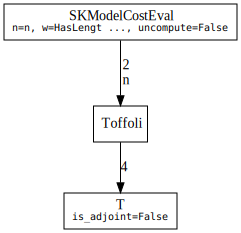

### TCounts for SKModelCostEval(n)

<IPython.core.display.Math object>

In [ ]:
@attrs.frozen
class SKModelCostEval(Bloq):
    r"""Implements the cost function evaluation oracle $O^{\text{direct}}$ for SK-Model.
    Evaluates the cost function $C(z)$ for SK-Model and stores the output in a new clean register.
    The oracle is defined as
    $$
        O^{\text{direct}}|z\rangle |0\rangle^{\otimes b_{\text{dir}}}  = |z\rangle |c(z)\rangle
    $$
    Here $b_{\text{dir}}$ is the bitsize of the newly allocated ancilla register and in the case of
    SK model, it is equal to $2\log{N}$.

    Args:
        n: Size of the spin system described by the SK model.
        w: A tuple of size $n \choose 2$ describing coefficients ($\in \{0, 1\}$) for the
            cost function $C(z)$.
        uncompute: Whether to uncompute the cost function instead.

    Registers:
      x: A `self.n`-bit fixed-point register of type QFxp(self.n, self.n).
      cost_reg: A RIGHT(/LEFT) register corresponding to the newly allocated (/deallocated)
        register that stores the value of computed cost function $C(x)$. The size of the
        register should be 2log(self.n) and be of type `QFxp(self.n, self.n)`


    References:
        [Compilation of Fault-Tolerant Quantum Heuristics for Combinatorial Optimization]
        (https://arxiv.org/abs/2007.07391)
        Section II.A.2: Direct energy oracle for SK model
    """

    n: int
    w: Tuple[int, ...]
    uncompute: bool = False

    @property
    def signature(self) -> Signature:
        side = Side.LEFT if self.uncompute else Side.RIGHT
        cost_reg_size = 2 * ceil(log2(self.n))
        x_reg = Register('x', QUInt(self.n))
        cost_reg = Register('cost_reg', QFxp(cost_reg_size, cost_reg_size, signed=False), side=side)
        return Signature([x_reg, cost_reg,])

    def build_call_graph(self, ssa: 'SympySymbolAllocator') -> Set['BloqCountT']:
        # Exercise: Implement the callgraph so you return `self.n^2` Toffoli when
        # self.uncompute is False and `0` Toffoli when self.uncompute is True.
        # We ignore the costs of cliffords here since cliffords are not the dominant cost.
        return {(Toffoli(), 0 if self.uncompute else self.n**2)}

    def adjoint(self) -> 'SKModelCostEval':
        # Exercise: Override the adjoint method to return `SKModelCostEval`
        return SKModelCostEval(self.n, self.w, not self.uncompute)

n = sympy.symbols('n')
sk_model_cost_eval = SKModelCostEval(n, get_weights(n))
g, sigma = sk_model_cost_eval.call_graph()
show_call_graph(g)
show_t_counts(sk_model_cost_eval, '### TCounts for SKModelCostEval(n)')

### Step-2: Implement phasing oracles using `QvrZPow` and `QvrPhaseGradient`

In [ ]:
import abc
from qualtran.bloqs.rotations.quantum_variable_rotation import QvrInterface, QvrZPow, QvrPhaseGradient
from qualtran.bloqs.rotations.phasing_via_cost_function import PhasingViaCostFunction

@attrs.frozen
class SKPhaseViaCostBase(Bloq, metaclass=abc.ABCMeta):
    r"""Implements the problem-dependent unitary $U_{C}(γ)=\exp(-i γ C)$ using `PhasingViaCostFunction`"""

    bitsize: SymbolicInt
    gamma: SymbolicFloat
    weights: Tuple[int, ...]
    eps: SymbolicFloat

    @property
    def signature(self) -> Signature:
        return self.phase_via_cost_function_oracle.signature

    @property
    def cost_reg(self) -> Register:
        return Register(
            'cost_reg',
            QFxp(2 * ceil(log2(self.bitsize)), 2 * ceil(log2(self.bitsize)), signed=False),
        )

    @property
    def cost_eval_oracle(self) -> Bloq:
        return SKModelCostEval(self.bitsize, self.weights)

    @property
    @abc.abstractmethod
    def qvr_oracle(self) -> QvrInterface:
        ...

    @property
    def phase_via_cost_function_oracle(self) -> PhasingViaCostFunction:
        # Exercise: Return a `PhasingViaCostFunction` oracle using `self.cost_eval_oracle`
        # and `self.qvr_oracle`,
        return PhasingViaCostFunction(self.cost_eval_oracle, self.qvr_oracle)

    def build_composite_bloq(self, bb: 'BloqBuilder', **soqs: 'SoquetT') -> Dict[str, 'SoquetT']:
        return bb.add_d(self.phase_via_cost_function_oracle, **soqs)

    def build_call_graph(self, ssa: 'SympySymbolAllocator') -> Set['BloqCountT']:
        # Exercise: Implement the callgraph by simply returning 1 count of
        # `self.phase_via_cost_function_oracle`
        return {(self.phase_via_cost_function_oracle, 1)}

    def __str__(self):
        return f'{self.__class__.__name__}[{self.gamma}, {self.eps}]'


@attrs.frozen
class SKPhaseViaCostQvrZPow(SKPhaseViaCostBase):
    r"""Implements the problem-dependent unitary $U_{C}(γ)=\exp(-i γ C) using `QvrZPow`$"""

    @property
    def qvr_oracle(self) -> QvrZPow:
        # Exercise: Return a `QvrZPow` bloq instantiated using self.cost_reg,
        # self.gamma and self.eps
        return QvrZPow(self.cost_reg, self.gamma, self.eps)


@attrs.frozen
class SKPhaseViaCostQvrPhaseGrad(SKPhaseViaCostBase):
    r"""Implements the problem-dependent unitary $U_{C}(γ)=\exp(-i γ C)$ using `QvrPhaseGradient`"""

    @property
    def qvr_oracle(self) -> QvrPhaseGradient:
        # Exercise: Return a `QvrPhaseGradient` bloq instantiated using self.cost_reg,
        # self.gamma and self.eps
        return QvrPhaseGradient(self.cost_reg, self.gamma, self.eps)

### Step-3: Perform numeric and symbolic cost analysis for `SKPhaseViaCostQvrZPow` and `SKPhaseViaCostQvrPhaseGrad`


### Numeric TCounts and Call graph for SKPhaseViaCostQvrZPow(n=100, gamma=0.1, eps=1e-05)

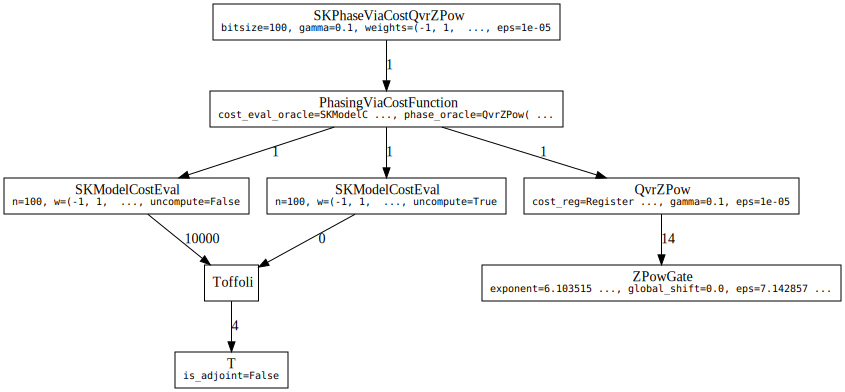

#### Counts totals:
 - `T`: 40000
 - `Z**6.103515625e-06`: 14

In [ ]:
def get_sk_phase_via_cost_qvr_zpow_bloq(n, gamma, eps):
    return SKPhaseViaCostQvrZPow(n, gamma, get_weights(n), eps)

@cache
def get_sk_phase_via_cost_qvr_zpow_t_counts(n, gamma, eps):
    bloq = get_sk_phase_via_cost_qvr_zpow_bloq(n, gamma, eps)
    _, sigma = bloq.call_graph()
    return t_counts_from_sigma(sigma)

n, gamma, eps = 100, 0.1, 1e-5
IPython.display.display(IPython.display.Markdown(f'### Numeric TCounts and Call graph for SKPhaseViaCostQvrZPow({n=}, {gamma=}, {eps=})'))
sk_phase_via_cost_qvr_zpow = SKPhaseViaCostQvrZPow(n, gamma, get_weights(n), eps)
sk_phase_via_cost_qvr_zpow_g, sk_phase_via_cost_qvr_zpow_sigma = sk_phase_via_cost_qvr_zpow.call_graph()
show_call_graph(sk_phase_via_cost_qvr_zpow_g)
show_counts_sigma(sk_phase_via_cost_qvr_zpow_sigma)

In [ ]:
n, gamma, eps = sympy.symbols('n \gamma \epsilon')
sk_phase_via_cost_qvr_zpow = SKPhaseViaCostQvrZPow(n, gamma, get_weights(n), eps)
show_t_counts(sk_phase_via_cost_qvr_zpow, '### TCounts for SKPhaseViaCostQvrZPow(n, gamma, eps)')

### TCounts for SKPhaseViaCostQvrZPow(n, gamma, eps)

<IPython.core.display.Math object>

### Numeric TCounts and Call graph for SKPhaseViaCostQvrPhaseGrad(n=100, gamma=0.1, eps=1e-05)

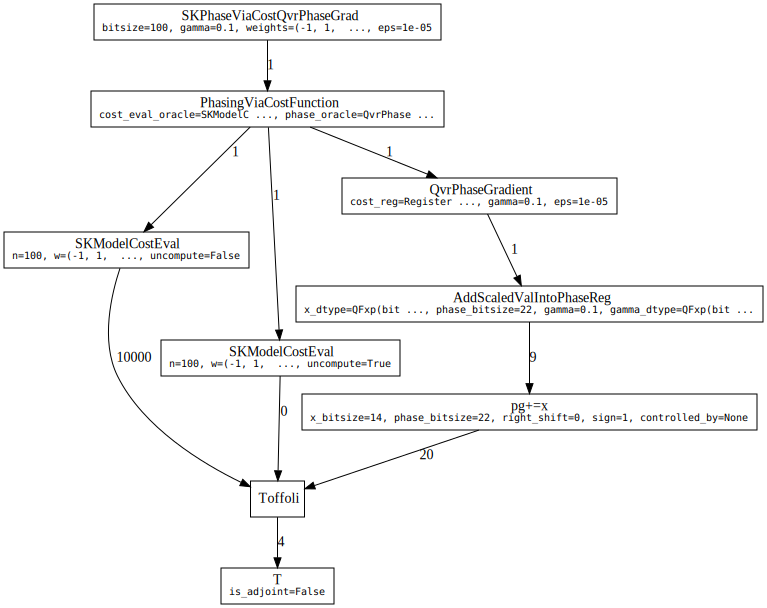

#### Counts totals:
 - `T`: 40720

In [ ]:
def get_sk_phase_via_cost_qvr_phase_grad_bloq(n, gamma, eps):
    return SKPhaseViaCostQvrPhaseGrad(n, gamma, get_weights(n), eps)

@cache
def get_sk_phase_via_cost_qvr_phase_grad_t_counts(n, gamma, eps):
    bloq = get_sk_phase_via_cost_qvr_phase_grad_bloq(n, gamma, eps)
    _, sigma = bloq.call_graph()
    return t_counts_from_sigma(sigma)
n, gamma, eps = 100, 0.1, 1e-5

IPython.display.display(IPython.display.Markdown(f'### Numeric TCounts and Call graph for SKPhaseViaCostQvrPhaseGrad({n=}, {gamma=}, {eps=})'))
sk_phase_via_cost_qvr_phase_grad = SKPhaseViaCostQvrPhaseGrad(n, gamma, get_weights(n), eps)
sk_phase_via_cost_qvr_phase_grad_g, sk_phase_via_cost_qvr_phase_grad_sigma = sk_phase_via_cost_qvr_phase_grad.call_graph()
show_call_graph(sk_phase_via_cost_qvr_phase_grad_g)
show_counts_sigma(sk_phase_via_cost_qvr_phase_grad_sigma)

In [ ]:
n, gamma, eps = sympy.symbols('n \gamma \epsilon')
sk_phase_via_cost_qvr_phase_grad = SKPhaseViaCostQvrPhaseGrad(n, gamma, get_weights(n), eps)
show_t_counts(sk_phase_via_cost_qvr_phase_grad, '### Symbolic TCounts for SKPhaseViaCostQvrPhaseGrad(n, gamma, eps)')

### Symbolic TCounts for SKPhaseViaCostQvrPhaseGrad(n, gamma, eps)

<IPython.core.display.Math object>

## Numerically compare costs for the three different phasing oracles -  `SKPhaseOracleNaiveRZZ`, `SKPhaseViaCostQvrZPow`, `SKPhaseViaCostQvrPhaseGrad`


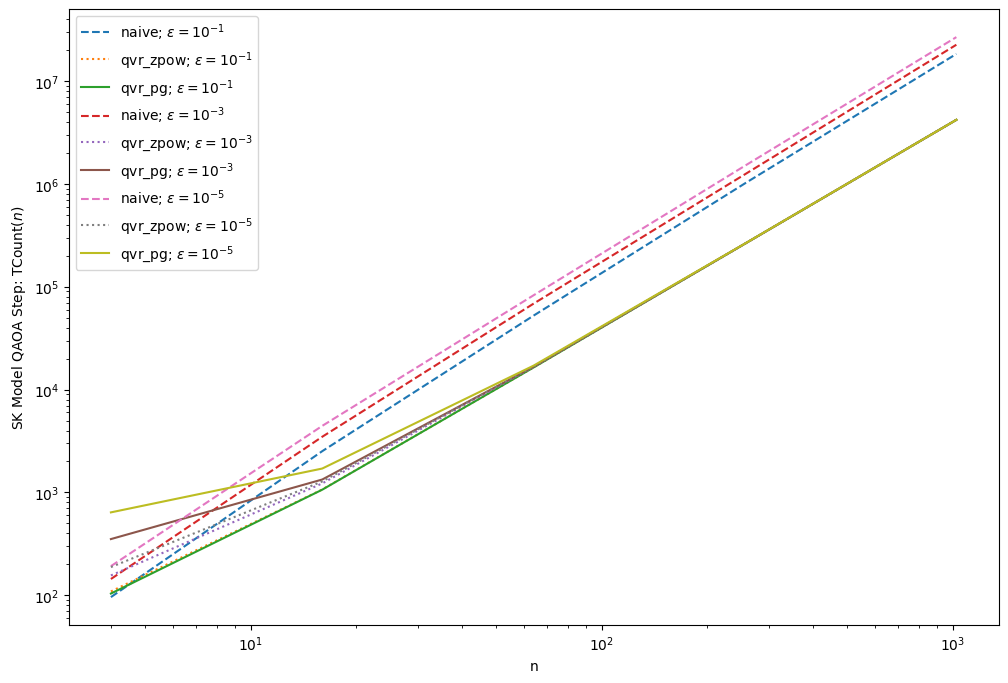

In [ ]:
import matplotlib.pyplot as plt

gamma = 0.1

n_vals = np.logspace(2, 10, 5, base=2, dtype=int).tolist()
plt.figure(figsize=(12, 8))

for eps_pow in [-1, -3, -5]:
    eps = 10**eps_pow
    cost_naive = [get_sk_phase_oracle_naive_rzz_t_counts(n, gamma, eps) for n in n_vals]
    cost_zpow = [get_sk_phase_via_cost_qvr_zpow_t_counts(n, gamma, eps) for n in n_vals]
    cost_qvr = [get_sk_phase_via_cost_qvr_phase_grad_t_counts(n, gamma, eps) for n in n_vals]
    plt.plot(n_vals, cost_naive, label=f'naive; $\epsilon=10^{{{eps_pow}}}$', linestyle='--')
    plt.plot(n_vals, cost_zpow, label=f'qvr_zpow; $\epsilon=10^{{{eps_pow}}}$', linestyle=':')
    plt.plot(n_vals, cost_qvr, label=f'qvr_pg; $\epsilon=10^{{{eps_pow}}}$')

plt.yscale('log')
plt.xscale('log')
plt.xlabel("n")
plt.ylabel("SK Model QAOA Step: TCount($n$)")
plt.legend()
plt.show()

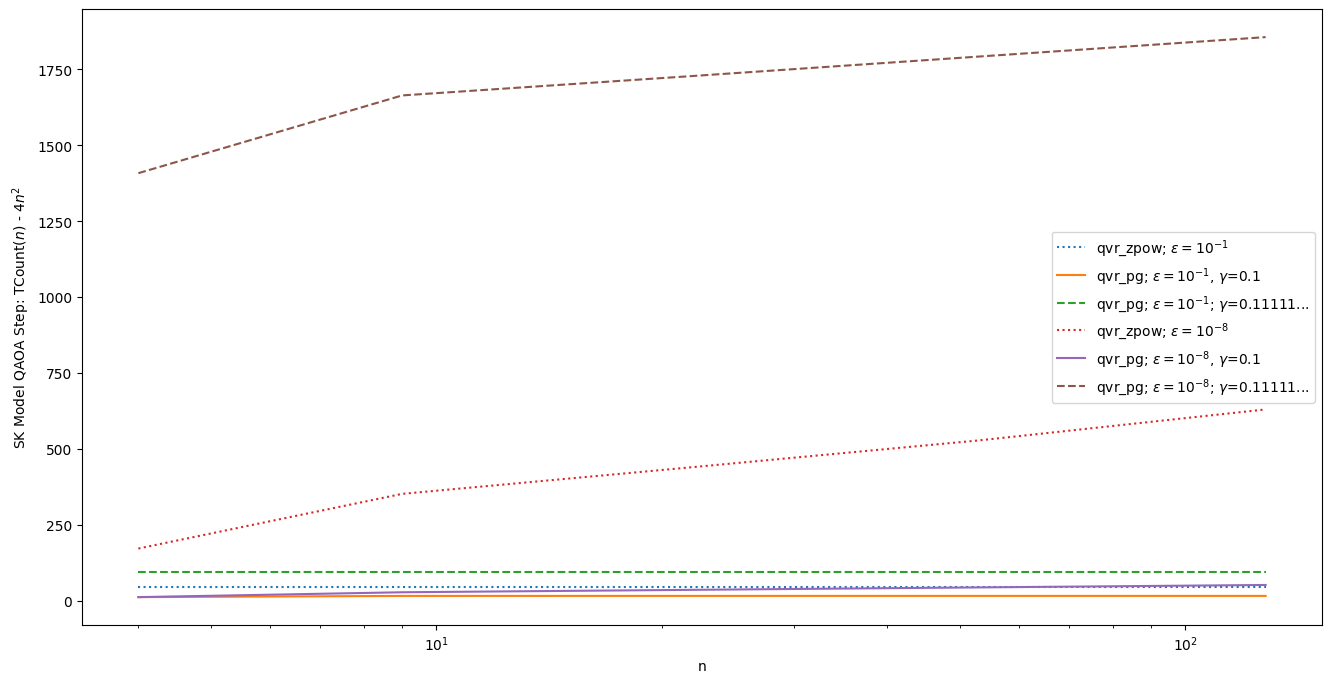

In [ ]:
import matplotlib.pyplot as plt

gamma_best, gamma_worst = 0.5, (2**20-1)/2**20
gamma=0.1
plt.figure(figsize=(16, 8))

# n_vals = np.logspace(2, 8, 10, base=2, dtype=int).tolist()
n_vals = np.logspace(2, 7, 5, base=2, dtype=int).tolist()

for eps_pow in [-1, -8]:
    eps = 10**eps_pow
    cost_zpow = [get_sk_phase_via_cost_qvr_zpow_t_counts(n, gamma, eps) - 4*n**2 for n in n_vals]
    cost_qvr_best = [get_sk_phase_via_cost_qvr_phase_grad_t_counts(n, gamma_best, eps) - 4*n**2 for n in n_vals]
    cost_qvr_worst = [get_sk_phase_via_cost_qvr_phase_grad_t_counts(n, gamma_worst, eps) - 4*n**2 for n in n_vals]
    plt.plot(n_vals, cost_zpow, label=f'qvr_zpow; $\epsilon=10^{{{eps_pow}}}$', linestyle=':')
    plt.plot(n_vals, cost_qvr_best, label=f'qvr_pg; $\epsilon=10^{{{eps_pow}}}$, $\gamma$=0.1')
    plt.plot(n_vals, cost_qvr_worst, label=f'qvr_pg; $\epsilon=10^{{{eps_pow}}}$; $\gamma$=0.11111...', linestyle='--')

plt.xlabel("n")
plt.ylabel("SK Model QAOA Step: TCount($n$) - $4 n^2$")
plt.xscale('log')
plt.legend()
plt.show()